In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Load data
df_min = pd.read_csv("../data/min_data.csv")
df_spy = pd.read_csv("../data/SPY.csv")
df_spy.Date = pd.to_datetime(df_spy.Date)
df_spy = df_spy.set_index("Date")
Price = df_spy.loc[:,"Adj Close"]

In [4]:
df_spy.index

DatetimeIndex(['1999-03-05', '1999-03-08', '1999-03-09', '1999-03-10',
               '1999-03-11', '1999-03-12', '1999-03-15', '1999-03-16',
               '1999-03-17', '1999-03-18',
               ...
               '2018-02-05', '2018-02-06', '2018-02-07', '2018-02-08',
               '2018-02-09', '2018-02-12', '2018-02-13', '2018-02-14',
               '2018-02-15', '2018-02-16'],
              dtype='datetime64[ns]', name='Date', length=4771, freq=None)

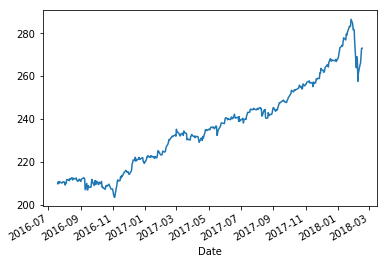

In [3]:
Price.iloc[-400:].plot()
plt.show()

# Micro-regime detection 

## 0. Suggestion from Natheneal
You might have more luck with the below strategies.. you had definitely written down the mean rev wrong but try these instead, they are simpler but should give greater variety to your results..

I’m not sure what you were trying to do with your selection of (7,28). I would do as follow:

 

Initially, split your data into short windows, i.e. 3 months or 63 observations, so roughly 30 windows for your dataset.

For this window, you now get one of four results. (Momentum(-1 for loss, +1 for profit), Mean rev(-1 for loss, +1 for profit). So (-1,-1), (1,-1), (-1,1) and (1,1).

Think of these as 4 possible regimes of the market, do a few backtests for your long_window and std to maximize the variance of your regime vector* (A,B), you should find that around a 1.2std param and a 20 day look back give good results.

Do not go below 0.7SD or shorter than 10 days as you’re just fitting to noise.

** The more variance in your classification over time, the greater the information value. I gave you constraint to stop signal/noise ratio dropping too low.**

You should get a variety of results for your regime vector, if you do not, focus on a specific period, say 2015-2017 and try to understand why the strategy is/isn’t working.. double check method. Plot the Bollinger bands/moving average on a chart alongside your position indicator to convince yourself how/why the method should work but is/isn’t. I’ve not implemented this myself, so I can’t guarantee it does work, but this is a crucial first step, you cannot proceed if you don’t make and lose money using your trading strategies as these are your initial classifiers. Come back to me else, I can suggest new methods.

Now you have a regime classification based on PNL of a trading strategy.

The next steps are to try to find features of the underlying dataset that you can train on (I can suggest some if you need help) that will decide whether or not to implement a mean reversion or a momentum trading strategy. Here you should be trying to improve the sharpe ratio of your combined strategy vs. them individually.

## 1. Backtest baseline momentum and mean-reversion strategies: 

### 1.1 Signals:
"Moving Average"(ma_window)
  * Moving Average = [ma_window]-bar simple moving average (MA) 
  
"Bollinger Bands"(bb_window, num_std) 
  * Middle Band = [bb_window]-bar simple moving average (MA) 
  * Upper Band = [bb_window]-bar MA + ( [bb_window]-bar standard deviation of price $\times$ [num_std]) 
  * Lower Band = [bb_window]-bar MA - ( [bb_window]-bar standard deviation of price $\times$ [num_std]) 

In [4]:
def compute_bollinger_band(series=Price, bb_window=20, num_std=1):
    bollinger_band_middle = series.rolling(window = bb_window).mean()
    rolling_std = series.rolling(window = bb_window).std()
    bollinger_band_upper = bollinger_band_middle+rolling_std*num_std
    bollinger_band_lower = bollinger_band_middle-rolling_std*num_std
    return bollinger_band_upper,bollinger_band_middle, bollinger_band_lower

### 1.2 Strategies: 
               

In [5]:
def momentum_strategy(series=Price, ma_window=5):
    ma = series.rolling(window = ma_window).mean()
    position = pd.Series(None,index = series.index)
    # long if asset crosses over ma_window-bar moving average 
    long = (series.shift() < ma.shift()) & (series > ma)
    # short if asset crosses down below ma_window-bar moving average 
    short = (series.shift() > ma.shift()) & (series < ma)
    
    position.loc[long] = +1
    position.loc[short] = -1

    position.fillna(method="ffill",inplace=True)
    position.fillna(0,inplace=True)
    return position.astype(np.int)

In [6]:
def mean_reversion_strategy(series=Price, bb_window=20, num_std=1):
    bb_upper, bb_middle, bb_lower = compute_bollinger_band(series, bb_window, num_std)
    position = pd.Series(None,index = series.index)
    
    # short if asset crosses over Upper Band
    short = series>=bb_upper
    position.loc[short] = -1
    
    # long if asset crosses down Lower Band
    long = series<=bb_lower
    position.loc[long] = +1
    
    
    open_position = position.fillna(method="ffill")
    # close short positon if asset crosses under Middle Band
    close_short = ( (series.shift()>=bb_middle.shift())&(series<bb_middle)&(np.allclose(open_position,-1)) )
    # close long positon if asset crosses from below Middle Band
    close_long = ( (series.shift()<=bb_middle.shift())&(series>bb_middle)&(np.allclose(open_position,+1)) )
    
    position.loc[close_short | close_long] = 0
    position.fillna(method="ffill",inplace=True)
    position.fillna(0,inplace=True)
    return position.astype(np.int)

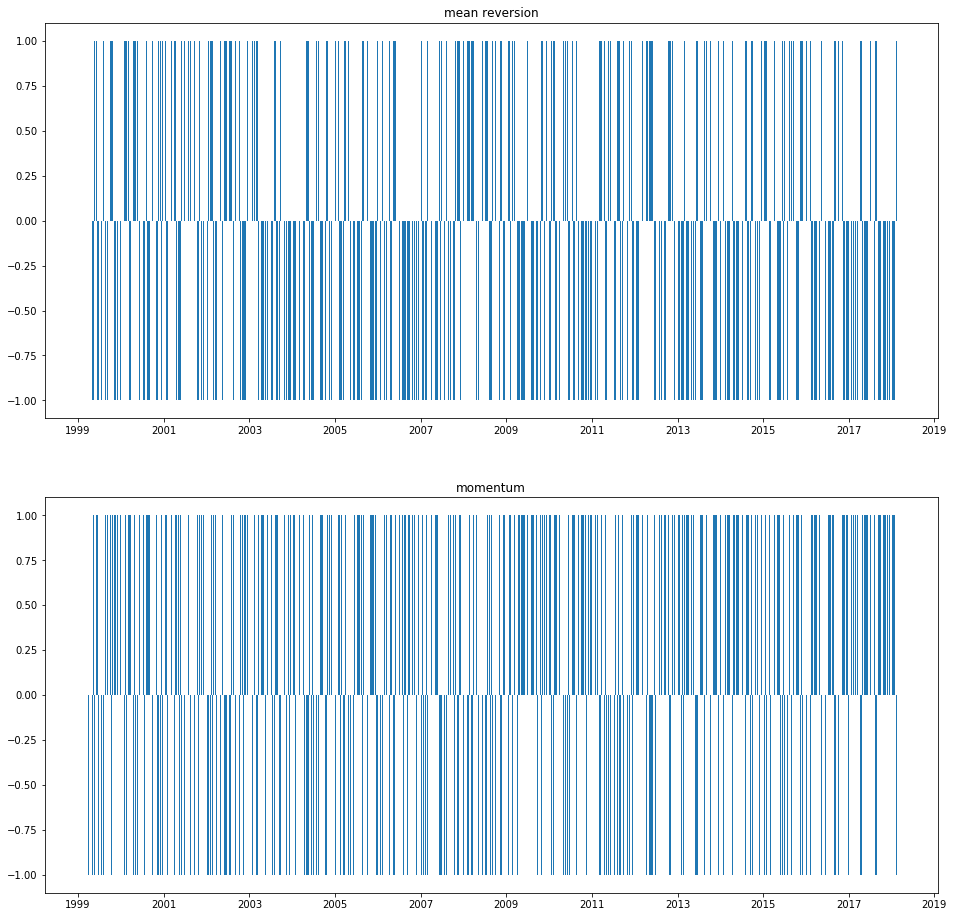

In [7]:
position_mean_reversion = mean_reversion_strategy(series=Price, bb_window=20, num_std=1)
fig,ax = plt.subplots(2,1,figsize=(16,16))
ax[0].bar(position_mean_reversion.index,position_mean_reversion.values)
ax[0].set_title("mean reversion")

position_momentum = momentum_strategy(series=Price, ma_window=10)
ax[1].bar(position_mean_reversion.index,position_momentum.values)
ax[1].set_title("momentum")
plt.show()

In [9]:
def compute_PNL(price = Price, position=None, reinvest = False):
    return_rate = price.shift(-1)/price - 1
    if reinvest:
        wealth_change = (1+position*return_rate)
        PNL = wealth_change.cumprod()
    else:
        PNL = (position*return_rate).cumsum()
    return PNL

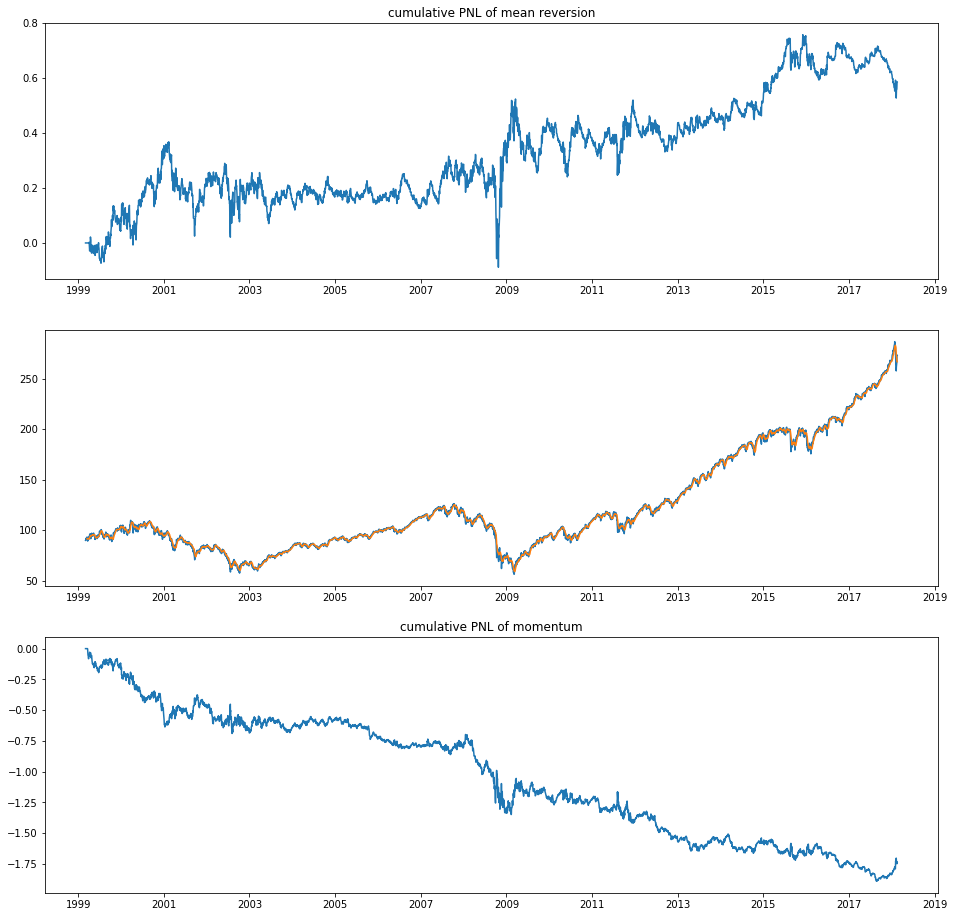

In [10]:
fig, axs = plt.subplots(3,1,figsize=(16,16))
PNL_mean_reversion = compute_PNL(price = Price, position=position_mean_reversion)
axs[0].plot(PNL_mean_reversion)
axs[0].set_title("cumulative PNL of mean reversion")
axs[1].plot(Price,label="SPY")
axs[1].plot(Price.rolling(window=10).mean(),label="MA10")
PNL_momentum = compute_PNL(price = Price, position=position_momentum)
axs[2].plot(PNL_momentum)
axs[2].set_title("cumulative PNL of momentum")
plt.show()

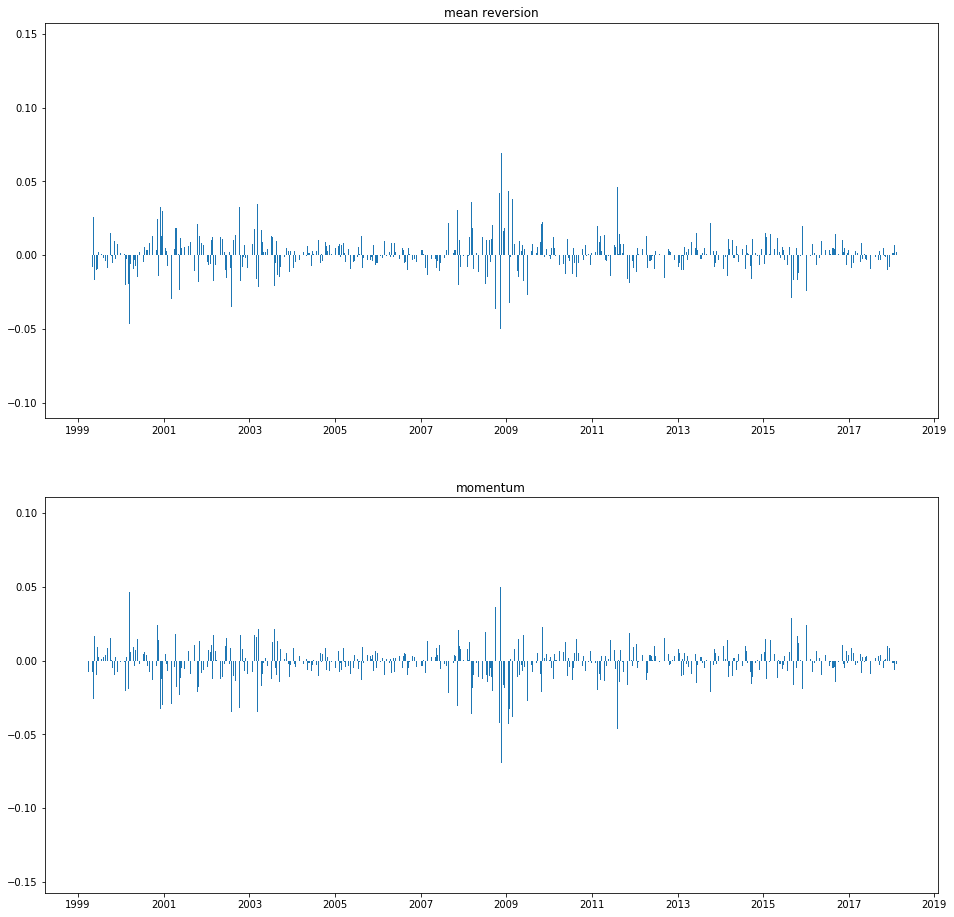

In [11]:
dailyPNL_mean_reversion = PNL_mean_reversion.diff().fillna(0)
dailyPNL_momentum = PNL_momentum.diff().fillna(0)

fig,ax = plt.subplots(2,1,figsize=(16,16))
ax[0].bar(dailyPNL_mean_reversion.index,dailyPNL_mean_reversion.values)
ax[0].set_title("mean reversion")

ax[1].bar(dailyPNL_momentum.index,dailyPNL_momentum.values)
ax[1].set_title("momentum")
plt.show()

Have a close look

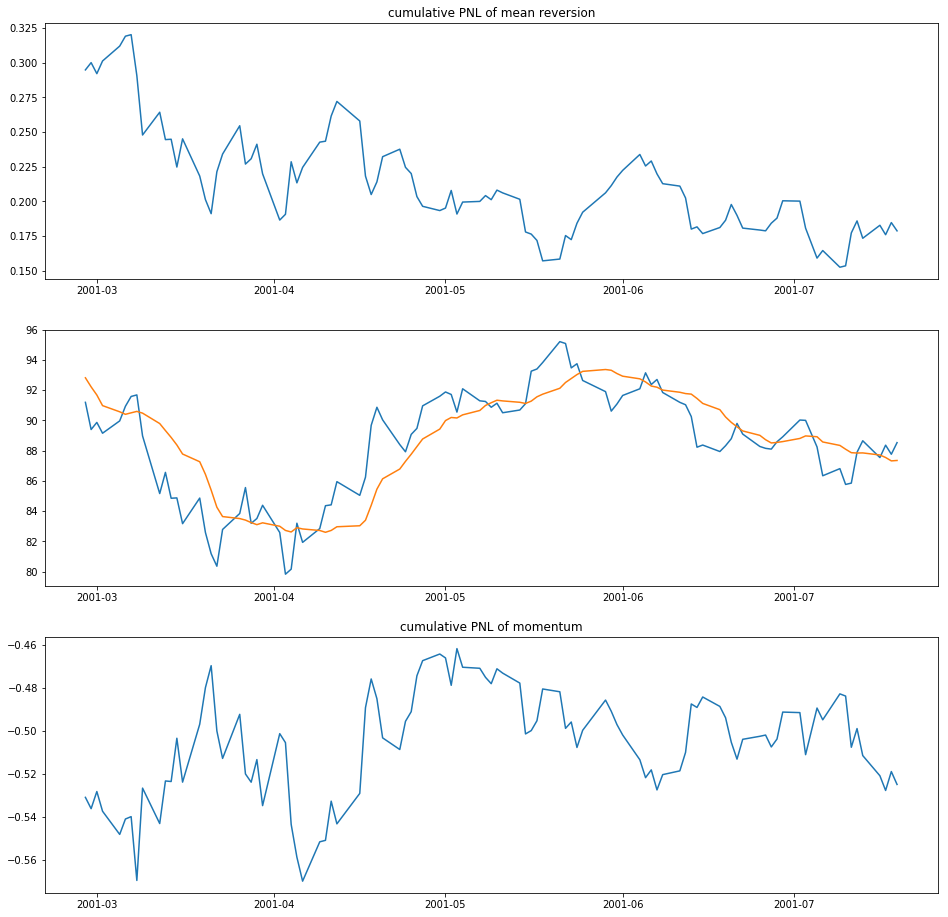

In [12]:
fig, axs = plt.subplots(3,1,figsize=(16,16))
PNL_mean_reversion = compute_PNL(price = Price, position=position_mean_reversion)
mask_idx = Price.index[500:600]
axs[0].plot(PNL_mean_reversion[mask_idx])
axs[0].set_title("cumulative PNL of mean reversion")
axs[1].plot(Price[mask_idx],label="SPY")
axs[1].plot(Price.rolling(window=10).mean()[mask_idx],label="MA10")
PNL_momentum = compute_PNL(price = Price, position=position_momentum)
axs[2].plot(PNL_momentum[mask_idx])
axs[2].set_title("cumulative PNL of momentum")
plt.show()

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline

In [28]:
# Load data
df = pd.read_csv("../data/SPY_.csv")
df.Date = pd.to_datetime(df.Date)
df = df.set_index("Date")
Price = df.loc[:,"Adj Close"]

In [35]:
def divide_period(window_length = 63, series = Price):
    """
    return the vector that divides the series into windows of fixed size
    """

    # define number of windows
    num_windows = len(series) // window_length

    # divide the Price into num_windows
    window_index = np.arange(0,(1+num_windows)*window_length,window_length)
    return window_index

In [37]:
# find the date
window_index = divide_period(window_length = 63, series = Price)
price_index = Price.index[window_index[1:]]

In [38]:
Price.index

DatetimeIndex(['2000-01-03', '2000-01-04', '2000-01-05', '2000-01-06',
               '2000-01-07', '2000-01-10', '2000-01-11', '2000-01-12',
               '2000-01-13', '2000-01-14',
               ...
               '2018-02-01', '2018-02-02', '2018-02-05', '2018-02-06',
               '2018-02-07', '2018-02-08', '2018-02-09', '2018-02-12',
               '2018-02-13', '2018-02-14'],
              dtype='datetime64[ns]', name='Date', length=4559, freq=None)

In [39]:
# compute_ema (the middle band)
def compute_ema(series=Price, short_window=5):
    return series.ewm(span=short_window,adjust=False).mean()

In [40]:
# compute the bollinger_band
def compute_bollinger_band(series=Price, span=20, num_std=1.2):
    bollinger_band_middle = Price.ewm(span=span).mean()
    rolling_std = Price.ewm(com=9.5).std()
    bollinger_band_upper = bollinger_band_middle+rolling_std*num_std
    bollinger_band_lower = bollinger_band_middle-rolling_std*num_std
    return bollinger_band_upper,bollinger_band_middle, bollinger_band_lower

In [41]:
def momentum_strategy(series=Price, long_window=20, short_window = 5, num_std=0.1, market_regime=1, window_length = 63):
    """
    for each period, check if momentum strategy's PNL is + or -
    return a nx1 vector Of gain or loss
    """
    # EMA indicator
    bb_upper, bb_middle, bb_lower = compute_bollinger_band(series, long_window, num_std)
    
    # periods

    window_index = divide_period(window_length = window_length, series = series[1:])
    
    # result vector
    res = np.zeros(len(window_index) - 1)
    
    # trade count
    trade_count = np.zeros(len(window_index) - 1)
    
    # momentum strategy
    # for every periods
    for i in range(len(window_index)-1):
        current_price = series[window_index[i]:window_index[i+1]]
        current_period = series.ewm(span=short_window,adjust=False).mean()[window_index[i]:window_index[i+1]]
        current_upper = bb_upper[window_index[i]:window_index[i+1]]
        current_middle = bb_middle[window_index[i]:window_index[i+1]]
        current_lower = bb_lower[window_index[i]:window_index[i+1]]
        
        # notice the the indicators are designed such that there is no chance of them overlap
        # price cross middle from below
        long_indicator = np.all([current_period > current_upper, current_period.shift(1) < current_upper.shift(1)], axis=0)
        
        # price cross middle from above
        close_long_indicator = np.all([current_period < current_middle, current_period.shift(1) > current_middle.shift(1)], axis=0)
    
        # price cross lower from above
        short_indicator = np.all([current_period < current_lower, current_period.shift(1) > current_lower.shift(1)], axis=0)
        
        # price cross middle from below
        close_short_indicator = np.all([current_period > current_middle, current_period.shift(1) < current_middle.shift(1)], axis=0)
        
        
        
        
        # make the strategy
        # if eixst position, close it anyway at end of the period
        position = 0
        pnl = 0
        pre_price = 0
        count = 0
        
        for j in range(window_length):

            # long indicator is activated
            if long_indicator[j] == True and position == 0:
                position = 1
                pre_price = current_price[j]
                
            # close long indicator is activated
            if close_long_indicator[j] == True and position == 1:
                position = 0
                pnl += current_price[j] - pre_price
                pre_price = 0
                count += 1
            
            # short indicator is activated
            if short_indicator[j] == True and position == 0:
                position = -1
                pre_price = current_price[j]
            
            # close short indicator is activated
            if close_short_indicator[j] == True and position == -1:
                position = 0
                pnl += pre_price - current_price[j]
                pre_price = 0
                count += 1
                
        # close any existing position
        if position != 0:
            if position == 1:
                pnl += current_price[window_length-1] - pre_price
            if position == -1:
                pnl += pre_price - current_price[window_length-1]
                
        res[i] = pnl 
        trade_count[i] = count
        
    return res, trade_count

In [42]:
def mean_reversion_strategy(series=Price, long_window=20, num_std=1.2, market_regime=1, window_length = 63):
    """
    for each period, check if mean reversion strategy's PNL is + or -
    return a nx1 vector Of gain or loss
    """
    # EMA indicator
    bb_upper, bb_middle, bb_lower = compute_bollinger_band(series, long_window, num_std)
    
    # periods
    window_index = divide_period(window_length = window_length, series = series[1:])
    
    # result vector
    res = np.zeros(len(window_index) - 1)
    
    # trade count
    trade_count = np.zeros(len(window_index) - 1)
    
    # mean reversion strategy
    # for every periods
    """
    a=b=c=d=[]
    e=f=g=h=[]
    """ 
    
    for i in range(len(window_index)-1):

        current_period = series[window_index[i]:window_index[i+1]]
        current_upper = bb_upper[window_index[i]:window_index[i+1]]
        current_middle = bb_middle[window_index[i]:window_index[i+1]]
        current_lower = bb_lower[window_index[i]:window_index[i+1]]
        
        # notice the the indicators are designed such that there is no chance of them overlap
        # price cross lower from above
        long_indicator = np.all([current_period < current_lower, current_period.shift(1) > current_lower.shift(1)], axis=0)
        
        # price cross middle from below
        close_long_indicator = np.all([current_period > current_middle, current_period.shift(1) < current_middle.shift(1)], axis=0)
    
        # price cross middle from above
        close_short_indicator = np.all([current_period < current_middle, current_period.shift(1) > current_middle.shift(1)], axis=0)
        
        # price cross upper from below
        short_indicator = np.all([current_period > current_upper, current_period.shift(1) < current_upper.shift(1)], axis=0)
        
        
        ############
        """
        if i == 1:
            a=current_period
            b=current_upper
            c=current_middle
            d=current_lower
            
            e=long_indicator
            f=close_long_indicator
            g=close_short_indicator
            h=short_indicator
        """    
        ############
        # make the strategy
        # if eixst position, close it anyway at end of the period
        position = 0
        pnl = 0
        pre_price = 0
        count = 0
        for j in range(window_length):
                
            # long indicator is activated
            if long_indicator[j] == True and position == 0:
                position = 1
                pre_price = current_period[j]
                
            # close long indicator is activated
            if close_long_indicator[j] == True and position == 1:
                position = 0
                pnl += current_period[j] - pre_price
                pre_price = 0
                count += 1
            
            # short indicator is activated
            if short_indicator[j] == True and position == 0:
                position =  -1
                pre_price = current_period[j]
            
            # close short indicator is activated
            if close_short_indicator[j] == True and position == -1:
                position = 0
                pnl += pre_price - current_period[j]
                pre_price = 0
                count += 1
                
        # close any existing position
        if position != 0:
            if position == 1:
                pnl += current_period[window_length-1] - pre_price
            if position == -1:
                pnl += pre_price - current_period[window_length-1]
                
        res[i] = pnl 
        trade_count[i] = count
        
    return res, trade_count

# character the market regime from 63 days window
plots shows the distribution of window pnl and number of transactions 

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1156befd0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1156fddd8>], dtype=object)

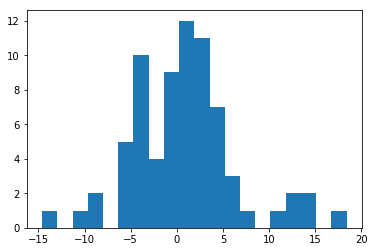

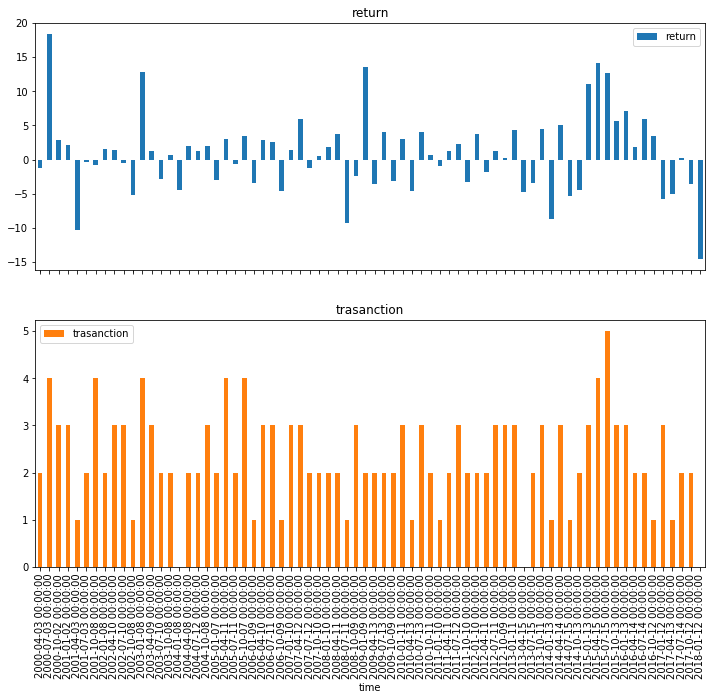

In [59]:
from matplotlib.ticker import *


return_MR, trade_count_MR=mean_reversion_strategy();
plt.hist(return_MR, bins=20);
MR_series = pd.DataFrame({'trasanction':trade_count_MR, 'time':price_index.values,'return':return_MR})

MR_series = MR_series.set_index("time")
MR_series.plot.bar(subplots=True, figsize=(12,10))

<Container object of 72 artists>

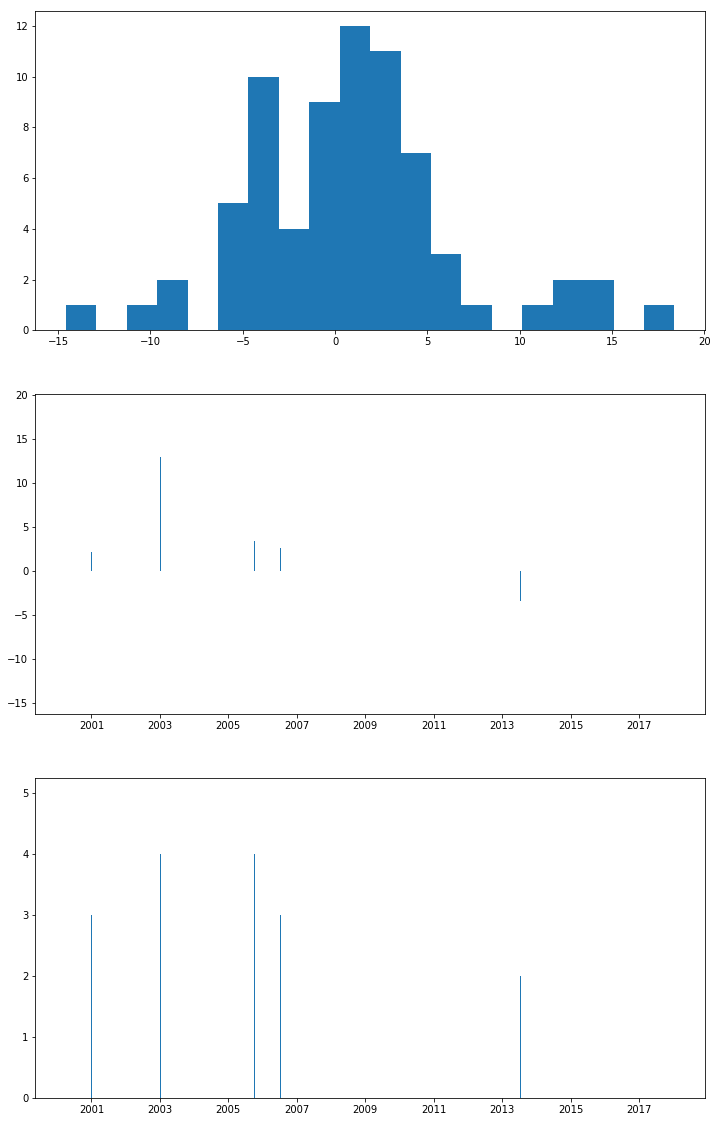

In [60]:
from matplotlib.ticker import *

fig, axs = plt.subplots(3,1,figsize=(12,20))
return_MR, trade_count_MR=mean_reversion_strategy();
axs[0].hist(return_MR, bins=20);
MR_series = pd.DataFrame({'trasanction':trade_count_MR, 'time':price_index.values,'return':return_MR})

MR_series = MR_series.set_index("time")
axs[1].bar(MR_series.index,MR_series.loc[:,"return"])

axs[2].bar(MR_series.index,MR_series.trasanction)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1139609e8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x11399f390>], dtype=object)

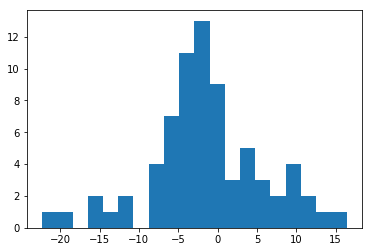

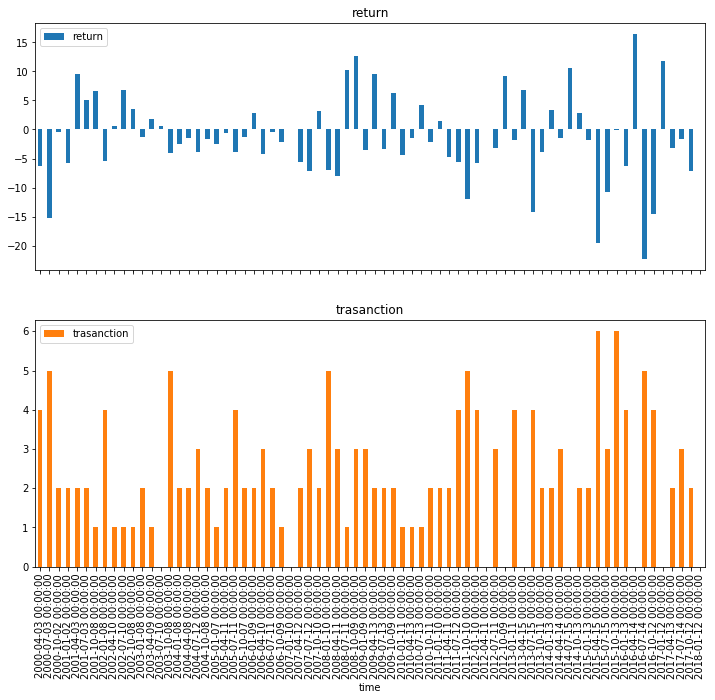

In [44]:
return_MO, trade_count_MO=momentum_strategy();
plt.hist(return_MO, bins=20);
MO_series = pd.DataFrame({'trasanction':trade_count_MO, 'time':price_index.values, 'return':return_MO})
MO_series = MO_series.set_index("time")
MO_series.plot.bar(subplots=True, figsize=(12,10))

In [61]:
b_return_MR = np.where(return_MR>0, 1, 0)

In [62]:
b_return_MO = np.where(return_MO>0, 1, 0)

In [65]:
regime = list(zip(b_return_MR,b_return_MO ))

In [66]:
r1 = (0,0)
r2 = (0,1)
r3 = (1,0)
r4 = (1,1)
regime_indicator = np.empty_like(b_return_MO)
for i in range(len(regime)):
    if regime[i] == r1:
        regime_indicator[i] = 0
    elif regime[i] == r2:
        regime_indicator[i] = 1
    elif regime[i] == r3:
        regime_indicator[i] = 2
    elif regime[i] == r4:
        regime_indicator[i] = 3
regime_df = pd.DataFrame({'frame':regime_indicator, 'time':MO_series.index.values}) 
regime_df.set_index("time");

# regime from window_size = 63 and std = 1.2
3 means both mean reversion and momentum

2 means mean reversion

1 means momentum

0 mean neither

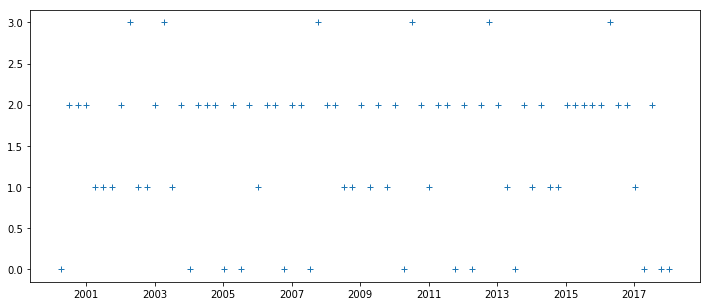

In [67]:
plt.figure(figsize=(12,5))
plt.plot_date(MO_series.index,regime_indicator, '+');

# find the window_size and std to maximize variance

In [68]:
# investigate the impact of window size
def find_window(start = 20, end = 80):
    """
    return: 
    an array of correlation between mean-reversion and momentum
    """
    corr_array = np.zeros(end-start)
    window_size_array = np.arange(start,end,1)
    for i in range(len(window_size_array)):
        return_MO, trade_count_MR=momentum_strategy(window_length=window_size_array[i]);
        return_MR, trade_count_MR=mean_reversion_strategy(window_length=window_size_array[i]);
        # convert into binary
        b_return_MR = np.where(return_MR>0, 1, 0)
        b_return_MO = np.where(return_MO>0, 1, 0)
        corr_array[i] = np.corrcoef(b_return_MR,b_return_MO)[1][0]
        
    return  corr_array,  window_size_array

In [69]:
corr_array,  window_size_array = find_window()

Text(0,0.5,'correlation')

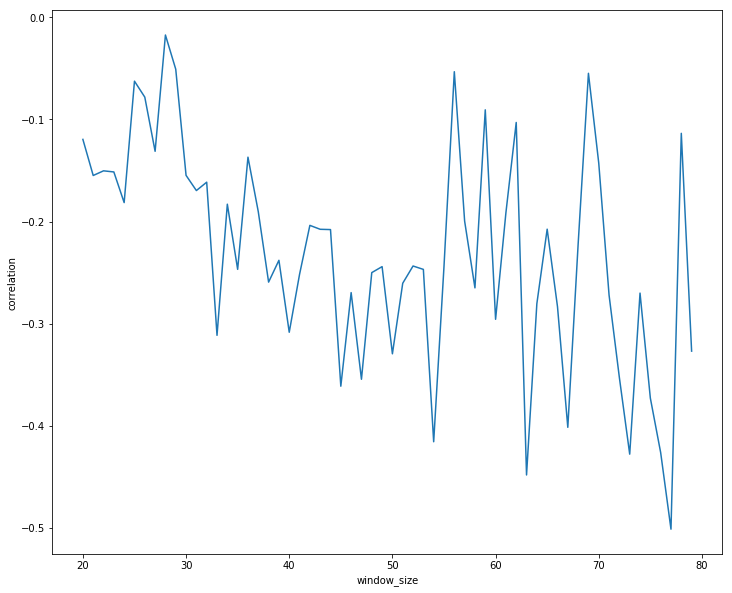

In [70]:
plt.figure(figsize=(12,10));
plt.plot(window_size_array, corr_array);
plt.xlabel('window_size')
plt.ylabel('correlation')

In [71]:
def find_paras(window=(50,80), std = (0.8, 2.1)):
    """
    return: 
    a matrix of correlation between mean-reversion and momentum
    """
    corr_array = np.zeros((window[1]-window[0], int((std[1]-std[0])/0.1)))
    
    window_size_array = np.arange(window[0],window[1],1)
    
    std_array = np.arange(std[0], std[1], 0.1)
    for i in range(len(window_size_array)):
        for j in range(len(std_array)):
            return_MO, trade_count_MR=momentum_strategy(window_length=window_size_array[i]);
            return_MR, trade_count_MR=mean_reversion_strategy(window_length=window_size_array[i], num_std=std_array[j]);
            # convert into binary
            b_return_MR = np.where(return_MR>0, 1, 0)
            b_return_MO = np.where(return_MO>0, 1, 0)
            corr_array[i,j] = np.corrcoef(b_return_MR,b_return_MO)[1][0]

    return  corr_array,  window_size_array, std_array

In [72]:
corr_array,  window_size_array, std_array = find_paras()

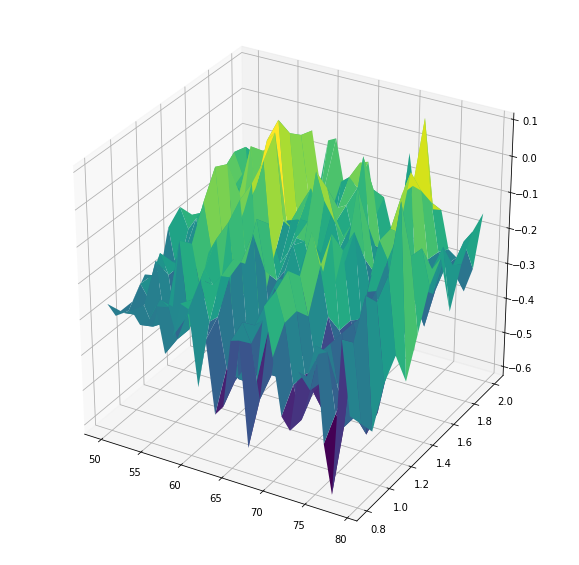

In [73]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
window_size_array, std_array = np.meshgrid(window_size_array, std_array)

ax = plt.axes(projection='3d')
ax.plot_surface(window_size_array, std_array, corr_array.T, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none');

# possible best params [window_size = 76 and std = 0.8]

3 means both mean reversion and momentum

2 means mean reversion

1 means momentum

0 mean neither

In [25]:
return_MO, trade_count_MR=momentum_strategy(window_length=76);
return_MR, trade_count_MR=mean_reversion_strategy(window_length=76, num_std=0.8);
b_return_MR = np.where(return_MR>0, 1, 0)
b_return_MO = np.where(return_MO>0, 1, 0)
np.corrcoef(b_return_MR,b_return_MO)[1][0]

-0.47571141904344799

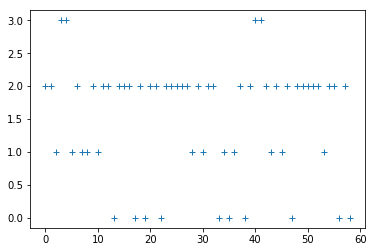

In [28]:
regime = zip(b_return_MR,b_return_MO )
r1 = (0,0)
r2 = (0,1)
r3 = (1,0)
r4 = (1,1)
regime_indicator = np.empty_like(b_return_MO)
for i in range(len(regime)):
    if regime[i] == r1:
        regime_indicator[i] = 0
    elif regime[i] == r2:
        regime_indicator[i] = 1
    elif regime[i] == r3:
        regime_indicator[i] = 2
    elif regime[i] == r4:
        regime_indicator[i] = 3
plt.plot(regime_indicator,'+')